In [1]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
%matplotlib inline

In [2]:
import pycuda.driver as cuda
cuda.init()
torch.cuda.current_device()

0

In [3]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = ImageFolderWithPaths(root="data/", transform=ToTensor())

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create the dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

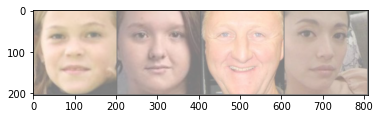

data/cropped/14_1_0_20170109204131257.jpg.chip.jpg
data/cropped/16_1_0_20170109214138699.jpg.chip.jpg
data/cropped/53_0_0_20170111202035978.jpg.chip.jpg
data/cropped/25_1_2_20170104021412148.jpg.chip.jpg


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, idk, filename = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))

for fname in filename:
    print(fname)

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cuda()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 47 * 47, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,2)  #age (0 to 1 * 100), gender (<0.5 -> F, >=0.5 -> M), race ((0 to 1) / nraces) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 47 * 47)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
net = Net()
net.to(torch.device("cuda:0"))
#loss_function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
def find_gender(filename):
    demographics = filename.split("_")
    gender = int(demographics[1])
    return gender

In [18]:
images.shape

torch.Size([4, 3, 200, 200])

In [22]:
net(images.cuda())

tensor([[-0.0025, -0.0303],
        [-0.0026, -0.0323],
        [-0.0040, -0.0286],
        [ 0.0026, -0.0338]], device='cuda:0', grad_fn=<AddmmBackward>)

In [23]:
gender_map = {}

for (i, (_, _, labels)) in enumerate(trainloader):
    for label in labels:
        gender = find_gender(label)
        #tensor in shape [0,1] if female and [1, 0] if male
        gender_map[label] = [int(gender == 0), int(gender == 1)]

In [31]:
#Training the network
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _, labels = data

        #getting the gender info from labels
        genders = [gender_map[label] for label in labels]
        print(genders)

        # zero the parameter gradients
        optimizer.zero_grad()
        labels = torch.cuda.LongTensor(genders)
        labels = torch.reshape(labels, (4,2))

        # forward + backward + optimize
        outputs = net(inputs.cuda())
                
        outputs = torch.reshape(outputs, (4,2))

        print(labels, outputs)

        
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[[0, 1], [0, 1], [1, 0], [0, 1]]
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1]], device='cuda:0') tensor([[-0.0041, -0.0290],
        [ 0.0024, -0.0322],
        [-0.0006, -0.0299],
        [-0.0031, -0.0356]], device='cuda:0', grad_fn=<ViewBackward>)


RuntimeError: multi-target not supported at /pytorch/aten/src/THCUNN/generic/ClassNLLCriterion.cu:15